In [ ]:
import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')
    
import src.modules.training_settings as ts	
    
from monai.networks.nets import DenseNet121, DenseNet169, DenseNet201, DenseNet264
from monai.visualize.class_activation_maps import GradCAM 

from monai.transforms import (
	Compose,
	EnsureTyped,
	EnsureChannelFirstd,
	LoadImaged,
	NormalizeIntensityd,
	Orientationd,
    ConcatItemsd,
    ToTensord
)

torch.manual_seed(42)
random.seed(42)

In [4]:
def get_device():
	"""
	Returns the device available on the current machine.
	Args: None
	Returns:
		device (str): name of the device available.
	"""
	device = 'cpu'
	if torch.backends.mps.is_available():
		device = 'mps'
	elif torch.cuda.is_available():
		device = 'cuda'
        
	return device

## Get test data

In [ ]:
train_df = pd.read_csv('path/train.csv')
val_df = pd.read_csv('path/validation.csv')
test_df = pd.read_csv('path/test.csv')

In [34]:
_, _, test_df, _ = ts.set_classification_problem_dataframes(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    type='binary',
    subtype='ADvsEarly'
)

In [37]:
test_set_dict = ts.get_datasets_dict(test_df, '/kaggle/input/datath/upload/upload/test_preprocess')

## Define transformations

In [38]:
keys = ['left', 'right']

transform_pipe = Compose([
        LoadImaged(keys=keys, reader='NibabelReader', image_only=True),
        EnsureTyped(keys=keys, dtype=torch.float32),
        EnsureTyped(keys='data', dtype=torch.float32),
        EnsureChannelFirstd(keys=keys),
        EnsureChannelFirstd(keys='data', channel_dim='no_channel'),
        Orientationd(keys=keys, axcodes='RAS'),
        NormalizeIntensityd(keys=keys, nonzero=True, channel_wise=True),
        ConcatItemsd(keys=keys, name='image', dim=1),
        ToTensord(keys='image', device=get_device(), track_meta=False),
        ToTensord(keys='data', device=get_device(), track_meta=False)
    ])

cache_settings = dict(
    transform=transform_pipe,
    cache_rate=1.0,
    num_workers=None,
    progress=False
)

## Load pre-trained model from weights

In [ ]:
model_loaded = torch.load(
    'path_to_pt_file', 
    weights_only=True,
    map_location=torch.device(get_device())
)

In [42]:
settings = dict(
    spatial_dims=3, 
    in_channels=1,
    out_channels=2, 
    dropout_prob=.1,   
)

In [ ]:
dense121 = DenseNet121(**settings)
dense169 = DenseNet169(**settings)
dense201 = DenseNet201(**settings)
dense264 = DenseNet264(**settings)

# Change this to one of the four densenet depending on the downloaded checkpoint
model = dense201

model.load_state_dict(
    model_loaded['network'],
)

model = model.to(get_device())

## Load predictions

In [44]:
from monai.data import CacheDataset, DataLoader

test_dataset = CacheDataset(test_set_dict, **cache_settings)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,)

In [45]:
y_true = []
y_pred = []
y_proba = []
data_key_name=['image', 'data']

model.eval()

with torch.no_grad():
    for b in test_loader:
        model_input = {k: v for k, v in zip(b.keys(), b.values()) if k in data_key_name}
        output_logit = model(b['image'])
        output = torch.argmax(output_logit, dim=1)
        
        y_proba.append(torch.nn.Softmax(dim=1)(output_logit)[0].detach().cpu())
        y_pred.append(output.detach().cpu().item())
        y_true.append(b['label'].item())

In [23]:
import pickle

d = {'true': y_true, 'pred': y_pred, 'proba': y_proba}

with open('preds.pkl', 'wb') as f:
    pickle.dump(d, f)

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0, 1], digits=3))

              precision    recall  f1-score   support

           0      0.736     0.867     0.796        45
           1      0.500     0.300     0.375        20

    accuracy                          0.692        65
   macro avg      0.618     0.583     0.585        65
weighted avg      0.663     0.692     0.666        65



In [ ]:
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

roc_auc_score(y_true, y_proba, multi_class='ovr')

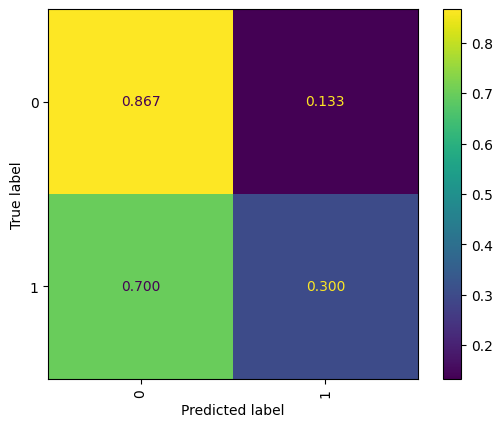

In [51]:
ConfusionMatrixDisplay.from_predictions(
            y_true, 
            y_pred,
            normalize="true", 
            values_format='.3f',
            xticks_rotation='vertical'
)

## Test

Calculate the Grad-CAM heatmap for every instance in the test set for every experiment, and for every densenet variant

In [ ]:
folders = ['ADvsMCI', 'ADvsNC', 'NCvsMCI', 'ternary']
models_names = ['_DenseNet121', '_DenseNet169', '_DenseNet201', '_DenseNet264']

if not os.path.isdir('gradcams'): os.mkdir('gradcams')

for i, subtype in enumerate(['ADvsEarly', 'CNvsAD', 'CNvsEarly', '']):
    print(f"--- {subtype if subtype != '' else 'ternary'} ---")
    
    train_df = pd.read_csv('path_to_train')
    val_df = pd.read_csv('path_to_validation')
    test_df = pd.read_csv('path_to_test')
    
    _, _, test_df, _ = ts.set_classification_problem_dataframes(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        type='binary' if subtype != '' else 'ternary',
        subtype=subtype
    )

    if subtype == 'ADvsEarly': 
        test_df['label'] = test_df['label'].map({1: 0, 2: 1})
    elif subtype == 'CNvsAD':
        test_df['label'] = test_df['label'].map({0: 0, 2: 1})

    test_set_dict = ts.get_datasets_dict(test_df, 'path_to_test')
    
    test_dataset = CacheDataset(test_set_dict, **cache_settings)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    settings = dict(
        spatial_dims=3, 
        in_channels=1,
        out_channels=3 if subtype == '' else 2, 
        dropout_prob=.1,   
    )

    dense121 = DenseNet121(**settings)
    dense169 = DenseNet169(**settings)
    dense201 = DenseNet201(**settings)
    dense264 = DenseNet264(**settings)

    models = [dense121, dense169, dense201, dense264]

    save_path = os.path.join('gradcams', subtype if subtype != '' else 'ternary')
    os.makedirs(save_path)

    for model, name in zip(models, models_names):
        cam_lst = []
        img_lst = []
        j = 0
        
        base_path = os.path.join('/', 'kaggle', 'input', 'results', name, folders[i])
        file_name = [f for f in os.listdir(base_path) if f.endswith('.pt')][0]

        print(f"\t- {name[1:]}: {os.path.join(base_path, file_name)}")
        
        model_loaded = torch.load(
            os.path.join(base_path, file_name), 
            weights_only=True,
            map_location=torch.device(get_device())
        )

        model.load_state_dict(model_loaded['network'])
        model = model.to(get_device())

        cam = GradCAM(
        			nn_module = model,
        			target_layers = 'class_layers.relu',
        )
        
        for b in test_loader:
            heatmap = cam(x=b['image']).squeeze().detach().cpu().numpy()
            input_image = b['image'].squeeze().detach().cpu().numpy()
            
            if j == 0: img_lst.append(input_image)
                
            cam_lst.append(heatmap)

        j += 1

        np.save(os.path.join(save_path, f'{name}_cams.np'), np.array(cam_lst), allow_pickle=True)

    np.save(os.path.join(save_path, f'{subtype}_test_set.np'), np.array(img_lst), allow_pickle=True )

--- ADvsEarly ---
	- DenseNet121: /kaggle/input/results/_DenseNet121/ADvsMCI/model_check_epoch_17.pt
	- DenseNet169: /kaggle/input/results/_DenseNet169/ADvsMCI/model_check_epoch_25.pt
	- DenseNet201: /kaggle/input/results/_DenseNet201/ADvsMCI/model_check_epoch_17.pt
	- DenseNet264: /kaggle/input/results/_DenseNet264/ADvsMCI/model_check_epoch_23.pt
--- CNvsAD ---
	- DenseNet121: /kaggle/input/results/_DenseNet121/ADvsNC/model_check_epoch_21.pt
	- DenseNet169: /kaggle/input/results/_DenseNet169/ADvsNC/model_check_epoch_28.pt
	- DenseNet201: /kaggle/input/results/_DenseNet201/ADvsNC/model_check_epoch_27.pt
	- DenseNet264: /kaggle/input/results/_DenseNet264/ADvsNC/model_check_epoch_23.pt
--- CNvsEarly ---
	- DenseNet121: /kaggle/input/results/_DenseNet121/NCvsMCI/model_check_epoch_33.pt
	- DenseNet169: /kaggle/input/results/_DenseNet169/NCvsMCI/model_check_epoch_24.pt
	- DenseNet201: /kaggle/input/results/_DenseNet201/NCvsMCI/model_check_epoch_50.pt
	- DenseNet264: /kaggle/input/results/_D